# Get Nbody Candidates

In [1]:
import rebound
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
%matplotlib inline

### Load data and stability predictions for System

In [2]:
system = "KOI-2086"    #KOI-0156, KOI-0168, KOI-2086

data = pd.read_csv("systems/%s_data.csv"%system)
results = pd.read_csv("systems/%s_results.csv"%system)
Ms = {}; Ms["KOI-0156"] = 0.56; Ms["KOI-0168"] = 1.11; Ms["KOI-2086"] = 1.04
epoch = 780

### Get Nbody candidates for Sunnyvale
Randomly sample from three stability probability ranges (low, medium, high).

In [3]:
N_samples = 201
random.seed(42)
i1 = random.sample(np.where((results["predict_proba"] > 0.5)&(results["predict_proba"] < 0.8))[0],N_samples/3)
i2 = random.sample(np.where((results["predict_proba"] > 0.95)&(results["predict_proba"] < 1))[0],N_samples/3)
i3 = random.sample(np.where((results["predict_proba"] > 0)&(results["predict_proba"] < 0.2))[0],N_samples/3)
index = np.concatenate((i1,i2,i3))

In [4]:
data.loc[index].head()

,Unnamed: 0,m1,T1,P1,h1,k1,m2,T2,P2,h2,k2,m3,T3,P3,h3,k3
1230,1230,4.530855,782.277004,7.133316,0.012195,0.106623,3.956276,786.584302,8.918454,0.041161,0.072448,4.537668,780.277656,11.898409,0.001456,0.086238
60,60,4.547456,782.280037,7.133255,-0.006656,0.053905,3.373306,786.583675,8.918705,0.021472,0.025298,3.563987,780.278621,11.897841,-0.008360,0.043636
548,548,4.474383,782.279991,7.133339,-0.047261,-0.050273,3.059205,786.579632,8.918902,-0.017928,-0.068755,4.672306,780.281953,11.897719,-0.040550,-0.035504
479,479,3.608257,782.281796,7.133298,-0.069667,-0.019255,3.899398,786.576819,8.918871,-0.037733,-0.040086,3.966241,780.277549,11.898036,-0.060336,-0.010253
1372,1372,4.447658,782.278745,7.133359,-0.007968,0.057125,3.084179,786.583734,8.918563,0.019812,0.029353,3.974266,780.272778,11.898063,-0.008526,0.046389


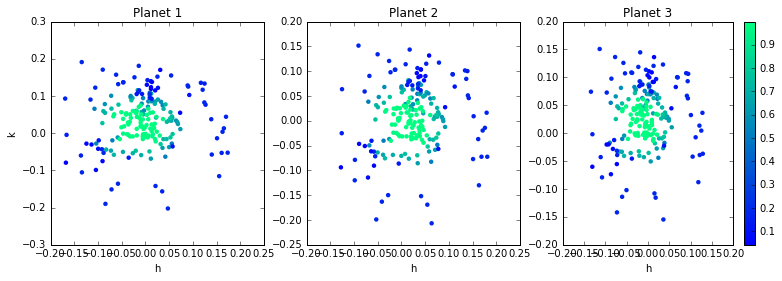

In [9]:
# Plot Nbody Candidates
x = "h"
y = "k"
proba = results["predict_proba"].loc[index].values

colorbar = 'winter'
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[13, 4])
ax1.scatter(data["%s1"%x].loc[index], data["%s1"%y].loc[index], c=proba, cmap=colorbar, lw=0)
ax2.scatter(data["%s2"%x].loc[index], data["%s2"%y].loc[index], c=proba, cmap=colorbar, lw=0)
c=ax3.scatter(data["%s3"%x].loc[index], data["%s3"%y].loc[index], c=proba, cmap=colorbar, lw=0)

ax1.set_ylabel(y) 
ax1.set_xlabel(x)
ax2.set_xlabel(x)
ax3.set_xlabel(x)
ax1.set_title("Planet 1")
ax2.set_title("Planet 2")
ax3.set_title("Planet 3")
cb = f.colorbar(c)
plt.savefig("images/%s_%s%s_Nbodycandidates.png"%(system,x,y))

## Make Sunnyvale Jobs

In [5]:
norbits = 1e9            #number of orbits of innermost planet
dir = 'jobs/'

f2 = open("systems/%s_NbodyIDs.csv"%system,"w"); f2.write("Nbody IDs\n")
for shadow in [0,1]:
    for sample in data.loc[index].iterrows():
        id_ = sample[0]    #id number of sample
        job_name = "%s_1e%dorbits_id%d_shadow%d"%(system,int(np.log10(norbits)),id_,shadow)
        sh_script_name = "%s%s"%(dir,job_name)
        with open(sh_script_name, 'w') as f:
            f_head = open('job_header_sunnyvale','r')
            f.write(f_head.read())
            f_head.close()
            f.write('#PBS -N %s \n'%job_name)
            f.write('# EVERYTHING ABOVE THIS COMMENT IS NECESSARY, SHOULD ONLY CHANGE nodes,ppn,walltime and my_job_name VALUES\n')
            f.write('cd $PBS_O_WORKDIR\n')      #This will be the home stability_predict directory
            f.write('source ../venv/bin/activate \n')
            f.write('python run_Nbody.py %d %f %.2f %d %d %s >& batch.output\n'%(id_,Ms[system],epoch,norbits,shadow,job_name))
        f.close()
        if shadow == 0:
            f2.write("%d\n"%id_)
f2.close()